# Model Training & Tracking
## Credit Risk Prediction Model Development
# Run this notebook to train and track models with MLflow

In [2]:
import mlflow
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score, 
                           precision_score, recall_score, f1_score,
                           ConfusionMatrixDisplay, RocCurveDisplay)
from pathlib import Path
import matplotlib.pyplot as plt
import os

### 1. MLflow Setup (Windows Compatible)

In [5]:
def setup_mlflow():
    """Configure MLflow tracking with Windows compatibility"""
    # Create mlruns directory if not exists
    mlruns_dir = Path.cwd().parent / "mlruns"  # Goes up one level from notebooks/
    mlruns_dir.mkdir(exist_ok=True)
    
    # Windows-compatible URI
    tracking_uri = f"file:///{str(mlruns_dir).replace('\\', '/')}"
    mlflow.set_tracking_uri(tracking_uri)
    
    print(f"Tracking URI set to: {tracking_uri}")
    
    # Set experiment
    try:
        mlflow.set_experiment("CreditRisk")
    except Exception as e:
        print(f"Experiment setup warning: {str(e)}")

setup_mlflow()

Tracking URI set to: file:///d:/Projects/Python/credit-risk-model/mlruns


### 2. Load and Prepare Data

In [6]:
# Load data with correct relative path from notebooks/
data_path = Path("../Data/processed/model_features_with_target.csv")
assert data_path.exists(), f"Data not found at {data_path}"

df = pd.read_csv(data_path)
print(f"Data loaded with shape: {df.shape}")

# Prepare features/target
X = df.drop(columns=["is_high_risk", "customerid"])
y = df["is_high_risk"]

Data loaded with shape: (95662, 26)


## 3. Train Model with MLflow Tracking

2025/07/01 09:59:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 09:59:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'CreditRiskModel'.
Created version '1' of model 'CreditRiskModel'.


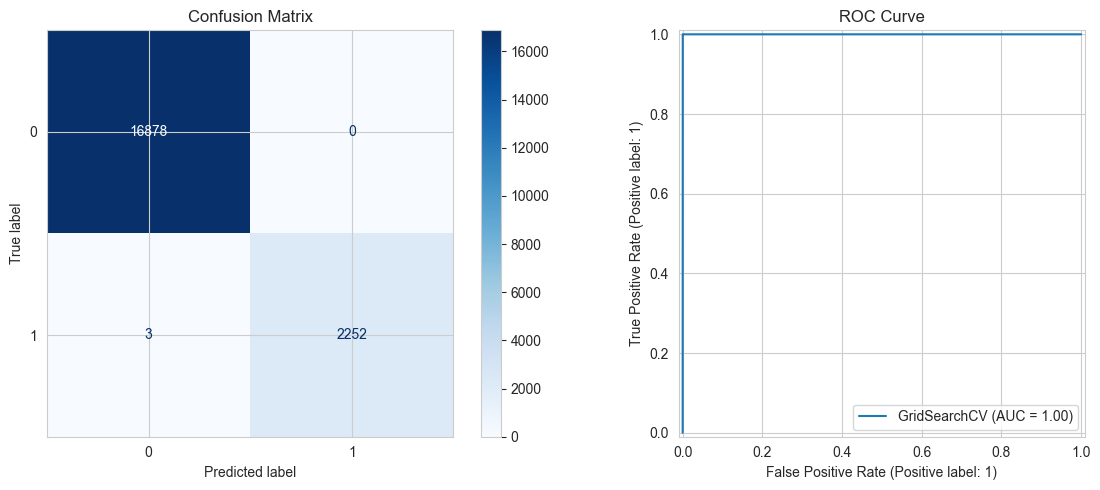

In [7]:
with mlflow.start_run(run_name="RF_Optimized") as run:
    # Split data (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    # Model configuration
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }
    
    # Training
    model = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Evaluation
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Log metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }
    mlflow.log_metrics(metrics)
    
    # Log parameters
    mlflow.log_params(model.best_params_)
    
    # Log model
    mlflow.sklearn.log_model(
        model.best_estimator_,
        "random_forest_model",
        registered_model_name="CreditRiskModel"
    )
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, 
        ax=ax1, 
        cmap='Blues'
    )
    ax1.set_title("Confusion Matrix")
    
    RocCurveDisplay.from_estimator(
        model, X_test, y_test, 
        ax=ax2
    )
    ax2.set_title("ROC Curve")
    
    plt.tight_layout()
    mlflow.log_figure(fig, "evaluation_plots.png")
    plt.show()

2025/07/01 09:57:10 INFO mlflow.tracking.fluent: Experiment with name 'CreditRisk' does not exist. Creating a new experiment.


Tracking URI set to: file:///d:/Projects/Python/credit-risk-model/mlruns


## 4. View Run Results

In [ ]:
# Run this command in a new terminal:
# ```
# mlflow ui --backend-store-uri file:///$(pwd)/../mlruns
# ```
print(f"Run ID: {run.info.run_id}")
print(f"Model URI: runs:/{run.info.run_id}/random_forest_model")

Run ID: 0decab28dfe245a9823826ea1ed66fe8
Model URI: runs:/0decab28dfe245a9823826ea1ed66fe8/random_forest_model


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, classification_report,
                           RocCurveDisplay, ConfusionMatrixDisplay)
import mlflow
import mlflow.sklearn
from pathlib import Path

# Setup
%matplotlib inline
sns.set_style("whitegrid")  # Updated from plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 100)
mlflow.set_tracking_uri("file://" + str(Path.cwd() / "mlruns"))
mlflow.set_experiment("credit_risk_modeling")

MlflowException: file://d:\Projects\Python\credit-risk-model\notebooks\mlruns is not a valid remote uri. For remote access on windows, please consider using a different scheme such as SMB (e.g. smb://<hostname>/<path>).

## 1. Load Processed Data

In [ ]:
data_path = "../data/processed/model_features_with_target.csv"
df = pd.read_csv(data_path)

# Verify target variable exists
assert 'is_high_risk' in df.columns, "Target variable 'is_high_risk' missing"

# Prepare features/target
X = df.drop(columns=['is_high_risk', 'customerid'])
y = df['is_high_risk']

print(f"Loaded {len(df)} records with {X.shape[1]} features")
print("\nClass distribution:")
print(y.value_counts(normalize=True))

## 2. Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

## 3. Model Training with Hyperparameter Tuning

In [ ]:
# Model configurations
models = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight='balanced', random_state=42),
        "params": {
            'C': np.logspace(-3, 3, 7),
            'solver': ['liblinear', 'saga']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5]
        }
    }
}
# Training loop with MLflow tracking
results = []
best_score = 0
best_model = None

for model_name, config in models.items():
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_param("model", model_name)
        
        # Hyperparameter tuning
        search = RandomizedSearchCV(
            config["model"],
            config["params"],
            n_iter=5,
            scoring='roc_auc',
            cv=5,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        
        # Evaluate
        y_pred = search.best_estimator_.predict(X_test)
        y_proba = search.best_estimator_.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_proba)
        }
        
        # Log metrics and parameters
        mlflow.log_metrics(metrics)
        mlflow.log_params(search.best_params_)
        mlflow.sklearn.log_model(search.best_estimator_, model_name)
        
        # Store results
        results.append({
            "model": model_name,
            "best_params": search.best_params_,
            **metrics
        })
        
        # Track best model
        if metrics["roc_auc"] > best_score:
            best_score = metrics["roc_auc"]
            best_model = search.best_estimator_
            best_model_name = model_name
            
        # Visualizations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        RocCurveDisplay.from_estimator(search.best_estimator_, X_test, y_test, ax=ax1)
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax2, normalize='true')
        plt.suptitle(f"{model_name} Performance")
        plt.tight_layout()
        mlflow.log_figure(fig, f"evaluation/{model_name}_metrics.png")
        plt.show()


## 4. Results Analysis

In [ ]:
# Display results dataframe
results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
display(results_df.style.background_gradient(cmap='Blues', subset=['roc_auc']))

# Register best model
if best_model:
    with mlflow.start_run(run_name="Best Model"):
        mlflow.log_metric("roc_auc", best_score)
        mlflow.sklearn.log_model(best_model, "best_model")
        mlflow.set_tag("best_model", best_model_name)
    
    print(f"\nBest model: {best_model_name} (ROC-AUC: {best_score:.4f})")
    
    # Save for deployment
    Path("../models").mkdir(exist_ok=True)
    mlflow.sklearn.save_model(best_model, "../models/best_model")
    
    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance.head(15), x='importance', y='feature')
        plt.title('Top 15 Important Features')
        plt.tight_layout()
        plt.show()

## 5. Unit Testing

In [ ]:
# Sample unit test (would normally be in tests/test_data_processing.py)
def test_feature_engineering():
    """Test that processed data has expected columns"""
    processed = pd.read_csv("../data/processed/model_features.csv")
    required_cols = {'num__recency', 'num__frequency', 'num__monetary'}
    assert required_cols.issubset(set(processed.columns)), "Missing RFM features"
    print("✅ Test passed - required columns present")

test_feature_engineering()